# Объединение данных анализ влияния курсов

В этой части анализа сделаем анализ влияния курсов на показатели эффективности. Сравним оценки до и после оубчения. Попробуем объединить таблицы для анализа и сделать общийе выводы по данному вопросу. Давайте рассмотрим задачу:

**Задача**

В группе компаний Тинькофф есть команда edTech, создающая платформу для обучающих курсов.
У команды edTech возникает вопрос, а какие курсы сильнее всего влияют на рабочие показатели сотрудников в колл-центре.
Помогите составить рекомендации, какие обучающие курсы стоит проходить сотрудникам, а какие курсы стоит убрать с edTech платформы.
Решение может быть как рекомендательной моделью для каждого из сотрудников, так и основано на бизнес-правилах и статистическом анализе (например, выделить для каждого департамента полезные курсы).

**Потенциальное решение**

Предполагается, что решение будет выполнено на Python, будет итоговая презентация. Решение может содержать блоки: эксплораторный анализ, Causal Inference методы, рекомендательную модель.
Ограничений на подход к решению нет, но для определения важности курсов советуем использовать методы анализа причинности. Подробнее можно почитать о них [здесь,](https://koch-kir.medium.com/causal-inference-from-observational-data-%D0%B8%D0%BB%D0%B8-%D0%BA%D0%B0%D0%BA-%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%81%D1%82%D0%B8-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82-%D0%B1%D0%B5%D0%B7-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82%D0%B0-afb84f2579f2) а также возможна консультация со стороны организаторов.

### Описание таблиц

**employees**

Информация о сотрудниках колл-центра
Поля:
- employee_id - идентификатор сотрудника
- sex – пол
- region - идентификатор федерального округа
- age – возраст
- head_employee_id – идентификатор руководителя
- exp_days – опыт в днях
- edu_degree – уровень образования
- department_id – индентификатор департамента, в котором работает сотрудник
- work_online_flg – флаг работы на удалённом режиме

**communications**

Информация о рабочих показателях сотрудников. Рассматривались рабочие коммункации операторов колл-центра
Поля:
- communication_id – идентификатор коммуникации
- communication_dt – дата коммуникации
- employee_id - идентификатор сотрудника
- communication_score – оценка качества коммуникации
- util_flg – флаг того, что клиент воспользовался банковским продуктом в течение 2 недель

**courses_passing**

Статиситка прохождения обучающих курсов сотрудниками
- course_id – идентификатор курса
- employee_id - идентификатор сотрудника
- pass_frac – доля прохождения курса
- start_dt – дата начала прохождения
- last_activity_dt – последняя активность сотрудника в обучающем курсе
- end_dt – дата окончания обучения. Если обучение пройдено не полностью, то NaN
- educ_duration_days – длительность полного обучения в днях. Если обучение пройдено не полностью, то NaN

**courses_info**

Информация о курсах
- course_id – идентификатор курса
- course_nm – название курса

**course_employee_sms**

Сводная таблица с нотификациями сотрудникам с предложением пройти обучение. Нотификации рассылались случайным образом
Поля:
- employee_id - идентификатор сотрудника
- course_i – флаг наличия нотификации

План предобработки данных.

В скобках указаны свойства данных, выполнимость которых восстанавливается после проведения этапа:

a) Очистка данных (Data cleaning)

Обнаружение и удаление/замена
*   аномалий/выбросов, шумов   (**корректность**)
*   пропусков                  (**полнота**)
*   некорректных значений      (**непротиворечивость, ясность**)

b) Сокращение данных (Data Reduction)
*   Сэмплирование
*   Отбор признаков
*   Отбор объектов
*   Удаление дубликатов      (**безызбыточность**)

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from causalinference import CausalModel
from sklearn.utils import resample
import dowhy
from dowhy import CausalModel

import warnings

m:\YandexDisk-bair.vambuev\MIPT\venvs\cuda_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Установка опции для отображения нормальных чисел
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Объединие таблиц в один датасет

Загризим все датасеты

In [4]:
# Загрузим датасет
communications = pd.read_csv('../data/src/communications.csv', sep=';', dtype={'employee_id': 'category'})
courses_passing = pd.read_csv('../data/src/courses_passing.csv', sep=';',  dtype={'employee_id': 'category'})
employees = pd.read_csv('../data/src/employees.csv', sep=';', dtype={'employee_id': 'category', 'head_employee_id': 'category', 'sex': 'category'})
course_employee_sms = pd.read_csv('../data/src/course_employee_sms.csv', sep=';')
courses_info = pd.read_csv('../data/src/courses_info.csv', sep=';')

In [5]:
# Измененим типов данных некоторых столбцов
communications['communication_dt'] = pd.to_datetime(communications['communication_dt'])

Начнем с объединения таблиц `employees` и `communications`. В качестве ключа используем `employee_id` 

In [81]:
# Объединение данных
combined_data = pd.merge(employees, communications, on='employee_id', how='inner')

In [82]:
# Просмотр первых нескольких строк объединенной таблицы
combined_data.head()

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,communication_score,util_flg
0,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,14921849450201131,2023-05-30,64,1
1,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,209971243798358860,2023-02-17,66,1
2,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,503301393365124883,2023-11-13,74,1
3,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,663626121892584935,2023-07-04,0,1
4,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,692074302944109718,2023-11-28,100,1


In [83]:
# Описание новой таблицы
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345246 entries, 0 to 5345245
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   employee_id          category      
 1   sex                  category      
 2   region               int64         
 3   age                  int64         
 4   head_employee_id     category      
 5   exp_days             int64         
 6   edu_degree           int64         
 7   department_id        int64         
 8   work_online_flg      int64         
 9   communication_id     int64         
 10  communication_dt     datetime64[ns]
 11  communication_score  int64         
 12  util_flg             int64         
dtypes: category(3), datetime64[ns](1), int64(9)
memory usage: 433.4 MB


Данные корректны. Далее добавим информацию из таблицы `courses_passing`

In [84]:
# Посмотрим первые 5 строк
courses_passing.head()

,course_id,employee_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
0,24,53ed35c7-4a2e-c275-b837-374f04396c03,1.00,2023-01-30 00:00:00,2023-02-05 00:00:00,2023-02-05 00:00:00,6.00
1,83,202cb962-ac59-075b-964b-07152d234b70,1.00,2023-08-29 00:00:00,2023-09-10 00:00:00,2023-09-10 00:00:00,12.00
2,4,05f971b5-ec19-6b8c-65b7-5d2ef8267331,1.00,2023-07-29 00:00:00,2023-08-09 00:00:00,2023-08-09 00:00:00,11.00
3,79,f4a331b7-a22d-1b23-7565-d8813a34d8ac,1.00,2023-05-30 00:00:00,2023-06-09 00:00:00,2023-06-09 00:00:00,10.00
4,6,aba3b6fd-5d18-6d28-e06f-f97135cade7f,1.00,2023-07-12 00:00:00,2023-07-22 00:00:00,2023-07-22 00:00:00,10.00


In [85]:
# Посмотрим информацию по датасету
courses_passing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10950 entries, 0 to 10949
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   course_id           10950 non-null  int64   
 1   employee_id         10950 non-null  category
 2   pass_frac           10950 non-null  float64 
 3   start_dt            10950 non-null  object  
 4   last_activity_dt    10950 non-null  object  
 5   end_dt              8404 non-null   object  
 6   educ_duration_days  8404 non-null   float64 
dtypes: category(1), float64(2), int64(1), object(3)
memory usage: 613.1+ KB


Тут надо скорректировать типы данных:

In [86]:
# Преобразование pass_frac в булев тип
courses_passing['pass_frac'] = courses_passing['pass_frac'] > 0

In [87]:
# Сначала заменим NaN на 0, затем преобразуем в int
courses_passing['educ_duration_days'] = courses_passing['educ_duration_days'].fillna(0).astype(int)

In [88]:
# Преобразование строковых дат в datetime формат
courses_passing['start_dt'] = pd.to_datetime(courses_passing['start_dt'])
courses_passing['last_activity_dt'] = pd.to_datetime(courses_passing['last_activity_dt'])
courses_passing['end_dt'] = pd.to_datetime(courses_passing['end_dt'])

In [89]:
# Посмотрим информацию по датасету
courses_passing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10950 entries, 0 to 10949
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   course_id           10950 non-null  int64         
 1   employee_id         10950 non-null  category      
 2   pass_frac           10950 non-null  bool          
 3   start_dt            10950 non-null  datetime64[ns]
 4   last_activity_dt    10950 non-null  datetime64[ns]
 5   end_dt              8404 non-null   datetime64[ns]
 6   educ_duration_days  10950 non-null  int32         
dtypes: bool(1), category(1), datetime64[ns](3), int32(1), int64(1)
memory usage: 495.4 KB


Теперь объединим таблицы `combined_data` и `courses_passing`

In [90]:
# Объединение combined_data с информацией о курсах
full_data = pd.merge(combined_data, courses_passing, on='employee_id', how='left')

In [91]:
# Рассмотрим первые 5 строк датасета
full_data.head(5)

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,communication_score,util_flg,course_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
0,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,14921849450201131,2023-05-30,64,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
1,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,209971243798358860,2023-02-17,66,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
2,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,503301393365124883,2023-11-13,74,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
3,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,663626121892584935,2023-07-04,0,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
4,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,692074302944109718,2023-11-28,100,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00


In [92]:
del combined_data

In [93]:
# Рассмотрим информацию о датасете
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020279 entries, 0 to 26020278
Data columns (total 19 columns):
 #   Column               Dtype         
---  ------               -----         
 0   employee_id          object        
 1   sex                  category      
 2   region               int64         
 3   age                  int64         
 4   head_employee_id     category      
 5   exp_days             int64         
 6   edu_degree           int64         
 7   department_id        int64         
 8   work_online_flg      int64         
 9   communication_id     int64         
 10  communication_dt     datetime64[ns]
 11  communication_score  int64         
 12  util_flg             int64         
 13  course_id            float64       
 14  pass_frac            object        
 15  start_dt             datetime64[ns]
 16  last_activity_dt     datetime64[ns]
 17  end_dt               datetime64[ns]
 18  educ_duration_days   float64       
dtypes: category(2), dat

In [94]:
# Посмотрим статистику по датасету
full_data.describe(include='all')

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,communication_score,util_flg,course_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
count,26020279,26020279,26020279.00,26020279.00,26020279,26020279.00,26020279.00,26020279.00,26020279.00,26020279.00,26020279,26020279.00,26020279.00,24624798.00,24624798,24624798,24624798,19129660,24624798.00
unique,2381,2,NaN,NaN,132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
top,f016e59c-7ad8-b1d7-2903-bb1aa5720d53,F,NaN,NaN,4c56ff4c-e4aa-f957-3aa5-dff913df997a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
freq,79825,13234381,NaN,NaN,583517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24389614,NaN,NaN,NaN,NaN
mean,NaN,NaN,2.74,31.82,NaN,393.29,1.62,1.45,0.56,500477168825372096.00,2023-07-10 12:13:59.563568128,59.76,0.76,44.29,NaN,2023-05-29 08:20:21.672694528,2023-06-07 06:41:32.622729472,2023-06-08 19:09:56.495035392,7.80
min,NaN,NaN,0.00,19.00,NaN,0.00,0.00,0.00,0.00,1052382138.00,2023-01-01 00:00:00,0.00,0.00,0.00,NaN,2023-01-11 00:00:00,2023-01-13 00:00:00,2023-01-14 00:00:00,0.00
25%,NaN,NaN,0.00,27.00,NaN,152.00,1.00,1.00,0.00,244119517333517120.00,2023-04-28 00:00:00,32.00,1.00,20.00,NaN,2023-04-12 00:00:00,2023-04-21 00:00:00,2023-04-22 00:00:00,5.00
50%,NaN,NaN,3.00,31.00,NaN,310.00,2.00,2.00,1.00,500871928628382784.00,2023-07-17 00:00:00,69.00,1.00,43.00,NaN,2023-05-26 00:00:00,2023-06-04 00:00:00,2023-06-06 00:00:00,9.00
75%,NaN,NaN,4.00,36.00,NaN,555.00,2.00,2.00,1.00,756839678108057984.00,2023-09-23 00:00:00,100.00,1.00,67.00,NaN,2023-07-16 00:00:00,2023-07-25 00:00:00,2023-07-27 00:00:00,11.00
max,NaN,NaN,7.00,60.00,NaN,2424.00,2.00,2.00,1.00,999999791018721664.00,2023-12-20 00:00:00,100.00,1.00,91.00,NaN,2023-11-01 00:00:00,2023-11-16 00:00:00,2023-11-16 00:00:00,23.00


## Обработка полученного датасета

Обработаем пропуски в датасете `full_data`

In [95]:
# Замена NaN в 'end_dt' и 'educ_duration_days'
full_data['end_dt'] = pd.to_datetime(full_data['end_dt'], errors='coerce')  # Преобразование в datetime, невалидные значения станут NaT
full_data['educ_duration_days'] = full_data['educ_duration_days'].fillna(0).astype(int)  # Замена NaN на 0 и преобразование в int

Теперь проверим нормализацию дат

In [96]:
# Убедимся, что все столбцы с датами имеют тип datetime
date_columns = ['communication_dt', 'start_dt', 'last_activity_dt', 'end_dt']
for col in date_columns:
    full_data[col] = pd.to_datetime(full_data[col], errors='coerce')  # Преобразование в datetime, невалидные значения станут NaT

In [97]:
# Проверка результатов
print(full_data[date_columns].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020279 entries, 0 to 26020278
Data columns (total 4 columns):
 #   Column            Dtype         
---  ------            -----         
 0   communication_dt  datetime64[ns]
 1   start_dt          datetime64[ns]
 2   last_activity_dt  datetime64[ns]
 3   end_dt            datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 794.1 MB
None


`Обработка пропущенных значений:` В `educ_duration_days` пропущенные значения заменяются на 0, что может быть интерпретировано как отсутствие завершения курса. В `end_dt` используется pd.to_datetime с errors='coerce', что преобразует некорректные или отсутствующие значения в NaT (Not a Time), что является аналогом NaN для временных данных.

`Нормализация дат:` Для каждого столбца с датами применяется pd.to_datetime для гарантии того, что все данные в этих столбцах будут иметь тип datetime64[ns], что обеспечивает унификацию формата и упрощает последующий анализ.

## Анализ полученного датасета

Сделаем анализ временных рядов и качество коммуникаций. Используя даты коммуникаций, можно анализировать, как изменяется качество коммуникаций сотрудников до и после прохождения определенных курсов.

Попробуем сделать следующим образом:
- Фильтрация данных: отфильтруем данные, чтобы оставить только те записи, где курс был завершен (по pass_frac и end_dt).
- Создание временного окна: определим временное окно до и после завершения курса (например, 30 дней до и после окончания курса).
- Группировка и агрегация данных: сравним среднее качество коммуникаций в этих временных окнах.
- Визуализация результатов: построим графики для визуального представления изменений.

In [25]:
# Фильтрация данных для анализа только успешно завершенных курсов
completed_courses = full_data[(full_data['pass_frac'] == 1.0) & (full_data['end_dt'].notna())]

# Определение временных окон для анализа
window_days = 30  # Количество дней для анализа до и после завершения курса

In [26]:
completed_courses

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,communication_score,util_flg,course_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
0,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,14921849450201131,2023-05-30,64,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
1,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,209971243798358860,2023-02-17,66,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
2,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,503301393365124883,2023-11-13,74,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
3,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,663626121892584935,2023-07-04,0,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
4,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,692074302944109718,2023-11-28,100,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26016472,a64c94ba-af36-8e18-40a1-324e839230de,F,0,35,67c6a1e7-ce56-d3d6-fa74-8ab6d9af3fd7,1018,2,2,0,47280606271759106,2023-03-09,87,1,6.00,True,2023-03-24,2023-04-02,2023-04-02,9
26016473,a64c94ba-af36-8e18-40a1-324e839230de,F,0,35,67c6a1e7-ce56-d3d6-fa74-8ab6d9af3fd7,1018,2,2,0,47280606271759106,2023-03-09,87,1,21.00,True,2023-07-18,2023-07-28,2023-07-28,10
26016474,a64c94ba-af36-8e18-40a1-324e839230de,F,0,35,67c6a1e7-ce56-d3d6-fa74-8ab6d9af3fd7,1018,2,2,0,47280606271759106,2023-03-09,87,1,57.00,True,2023-06-25,2023-07-02,2023-07-02,7
26016475,a64c94ba-af36-8e18-40a1-324e839230de,F,0,35,67c6a1e7-ce56-d3d6-fa74-8ab6d9af3fd7,1018,2,2,0,47280606271759106,2023-03-09,87,1,91.00,True,2023-06-15,2023-06-26,2023-06-26,11


In [27]:
# Добавляем временные окна к 'completed_courses'
completed_courses['start_window'] = completed_courses['end_dt'] - pd.Timedelta(days=window_days)
completed_courses['end_window'] = completed_courses['end_dt'] + pd.Timedelta(days=window_days)

In [28]:
# Сортировка данных в full_data по столбцу 'communication_dt'
full_data_sorted = full_data.sort_values(by='communication_dt')

# Сортировка данных в completed_courses по столбцу 'end_dt'
completed_courses_sorted = completed_courses.sort_values(by='end_dt')

# Произведем слияние датасетов
full_data_merged = pd.merge_asof(
    full_data_sorted,
    completed_courses_sorted[['employee_id', 'end_dt', 'start_window', 'end_window']],
    by='employee_id', 
    left_on='communication_dt', 
    right_on='end_dt',
    direction='nearest'
)

In [29]:
full_data_merged.head()

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,...,util_flg,course_id,pass_frac,start_dt,last_activity_dt,end_dt_x,educ_duration_days,end_dt_y,start_window,end_window
0,1f71e393-b380-9197-ed66-df836fe833e5,M,2,29,9bf31c7f-f062-936a-96d3-c8bd1f8f2ff3,704,2,1,1,215730748505413349,...,1,59.00,True,2023-06-06,2023-06-19,2023-06-19,13,2023-04-21,2023-03-22,2023-05-21
1,1c383cd3-0b7c-298a-b502-93adfecb7b18,F,5,23,eccbc87e-4b5c-e2fe-2830-8fd9f2a7baf3,27,1,2,1,9485013111822996,...,1,83.00,True,2023-02-23,2023-03-09,2023-03-09,14,2023-03-07,2023-02-05,2023-04-06
2,350db081-a661-5252-3535-4dd3e19b8c05,F,0,41,1ff1de77-4005-f8da-13f4-2943881c655f,312,1,2,1,237036008132889671,...,0,77.00,True,2023-09-30,2023-10-07,2023-10-07,7,2023-05-25,2023-04-25,2023-06-24
3,350db081-a661-5252-3535-4dd3e19b8c05,F,0,41,1ff1de77-4005-f8da-13f4-2943881c655f,312,1,2,1,938355228516016770,...,1,10.00,True,2023-06-07,2023-06-15,2023-06-15,8,2023-05-25,2023-04-25,2023-06-24
4,350db081-a661-5252-3535-4dd3e19b8c05,F,0,41,1ff1de77-4005-f8da-13f4-2943881c655f,312,1,2,1,938355228516016770,...,1,43.00,True,2023-05-17,2023-05-25,2023-05-25,8,2023-05-25,2023-04-25,2023-06-24


In [30]:
# Проверьте, содержит ли full_data_merged столбец 'end_dt'
full_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020279 entries, 0 to 26020278
Data columns (total 22 columns):
 #   Column               Dtype         
---  ------               -----         
 0   employee_id          object        
 1   sex                  category      
 2   region               int64         
 3   age                  int64         
 4   head_employee_id     category      
 5   exp_days             int64         
 6   edu_degree           int64         
 7   department_id        int64         
 8   work_online_flg      int64         
 9   communication_id     int64         
 10  communication_dt     datetime64[ns]
 11  communication_score  int64         
 12  util_flg             int64         
 13  course_id            float64       
 14  pass_frac            object        
 15  start_dt             datetime64[ns]
 16  last_activity_dt     datetime64[ns]
 17  end_dt_x             datetime64[ns]
 18  educ_duration_days   int32         
 19  end_dt_y           

In [31]:
# Создание масок для определения коммуникаций до и после завершения курса
mask_before = (full_data_merged['communication_dt'] >= full_data_merged['start_window']) & (full_data_merged['communication_dt'] <= full_data_merged['end_dt_y'])
mask_after = (full_data_merged['communication_dt'] >= full_data_merged['end_dt_y']) & (full_data_merged['communication_dt'] <= full_data_merged['end_window'])

communications_before = full_data_merged.loc[mask_before]
communications_after = full_data_merged.loc[mask_after]

In [32]:
# Агрегация данных для анализа
avg_communication_scores_before = communications_before.groupby('employee_id')['communication_score'].mean()
avg_communication_scores_after = communications_after.groupby('employee_id')['communication_score'].mean()

In [33]:
# Вывод результатов
display(avg_communication_scores_before.head())
display(avg_communication_scores_after.head())

employee_id
00411460-f7c9-2d21-24a6-7ea0f4cb5f85   57.17
006f52e9-102a-8d3b-e2fe-5614f42ba989   62.40
00a03ec6-533c-a7f5-c644-d198d815329c   62.58
00ac8ed3-b432-7bdd-4ebb-ebcb2ba10a00   57.15
00e26af6-ac3b-1c1c-49d7-c3d79c60d000   57.17
Name: communication_score, dtype: float64

employee_id
00411460-f7c9-2d21-24a6-7ea0f4cb5f85   58.81
006f52e9-102a-8d3b-e2fe-5614f42ba989   61.24
00a03ec6-533c-a7f5-c644-d198d815329c   62.35
00ac8ed3-b432-7bdd-4ebb-ebcb2ba10a00   57.85
00e26af6-ac3b-1c1c-49d7-c3d79c60d000   55.72
Name: communication_score, dtype: float64

In [34]:
# Слияние результатов для сравнения
comparison = pd.DataFrame({
    'Before': avg_communication_scores_before,
    'After': avg_communication_scores_after
}).dropna()

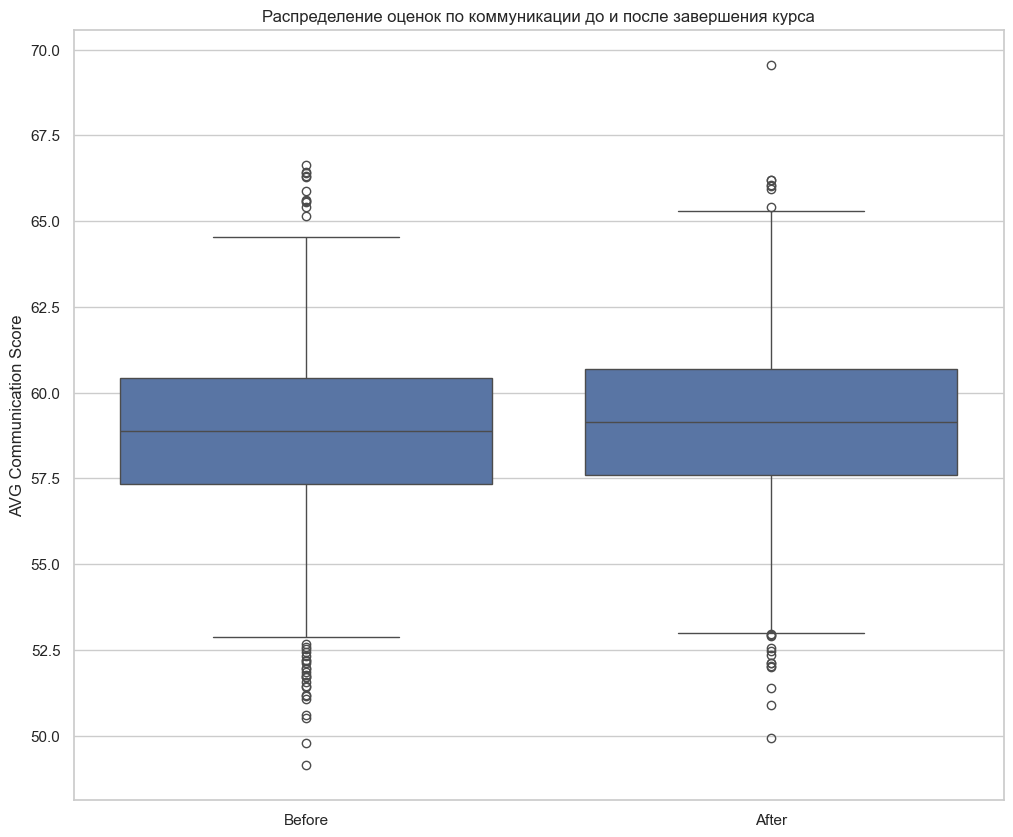

In [35]:
# Проверим Seaborn
sns.set_theme(style="whitegrid")

# Подготовка данных для боксплотов
data_for_boxplot = pd.melt(comparison.reset_index(), id_vars=['employee_id'], var_name='Period', value_name='Score')

# Построение боксплотов
plt.figure(figsize=(12, 10))
sns.boxplot(x='Period', y='Score', data=data_for_boxplot)
plt.title('Распределение оценок по коммуникации до и после завершения курса')
plt.xlabel('')
plt.ylabel('AVG Communication Score')
plt.show()

In [36]:
del avg_communication_scores_before
del avg_communication_scores_after
del communications_before
del communications_after
del full_data_merged

По графику можно увидеть, что:
- Центральная тенденция: медианное значение оценок коммуникаций после прохождения курса кажется несколько выше, чем до прохождения курса. Это может указывать на то, что в среднем курсы оказали положительное влияние на оценки коммуникаций.
- Разброс: межквартильный размах после прохождения курса кажется больше, чем до. Это может означать, что хотя средние оценки увеличились, разнообразие оценок коммуникаций также увеличилось. Иными словами, у некоторых сотрудников результаты улучшились более значительно, чем у других.
- Выбросы: на графиках до и после курса присутствуют выбросы. Это могут быть аномально низкие или высокие оценки по сравнению с основной массой данных. После курса количество выбросов, кажется, увеличилось, что может указывать на большее разнообразие в результатах коммуникаций сотрудников.
- Симметрия: распределение оценок до прохождения курса выглядит более симметричным, в то время как после курса боксплот выглядит более смещенным вверх, что может говорить о положительном смещении результатов.

Теперь попробуем сделать статистический и причинно-следственный анализ - использование методов Causal Inference для определения влияния прохождения курсов на рабочие показатели. Попробуем использовать пропенсити скоринг, чтобы оценить влияние прохождения курсов на оценки коммуникаций сотрудников. Пропенсити скоринг пытается сбалансировать наблюдаемые ковариаты между обработанными и контрольными группами, чтобы приблизить рандомизированное контролируемое исследование.

In [37]:
full_data.head()

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,communication_score,util_flg,course_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
0,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,14921849450201131,2023-05-30,64,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
1,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,209971243798358860,2023-02-17,66,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
2,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,503301393365124883,2023-11-13,74,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
3,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,663626121892584935,2023-07-04,0,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
4,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,692074302944109718,2023-11-28,100,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11


In [98]:
# Преобразование 'True'/'False' в 1/0
full_data['course_taken'] = full_data['pass_frac'].replace({'True': 1, 'False': 0})

In [99]:
mode_value = full_data['course_taken'].mode()[0]
full_data['course_taken'].fillna(mode_value, inplace=True)

In [100]:
# Создание временных признаков
full_data['time_since_last_activity'] = (full_data['communication_dt'] - full_data['last_activity_dt']).dt.days
full_data['time_since_end'] = (full_data['communication_dt'] - full_data['end_dt']).dt.days.fillna(0)

In [101]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020279 entries, 0 to 26020278
Data columns (total 22 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   employee_id               object        
 1   sex                       category      
 2   region                    int64         
 3   age                       int64         
 4   head_employee_id          category      
 5   exp_days                  int64         
 6   edu_degree                int64         
 7   department_id             int64         
 8   work_online_flg           int64         
 9   communication_id          int64         
 10  communication_dt          datetime64[ns]
 11  communication_score       int64         
 12  util_flg                  int64         
 13  course_id                 float64       
 14  pass_frac                 object        
 15  start_dt                  datetime64[ns]
 16  last_activity_dt          datetime64[ns]
 17  end_dt

In [102]:
# Дополнение списка признаков
feature_cols = ['sex', 'region', 'age', 'exp_days', 'edu_degree', 'department_id', 'work_online_flg', 'educ_duration_days', 'time_since_last_activity', 'time_since_end']
# Преобразование столбцов к типу 'category', если они уже не таковы
for col in ['sex', 'region', 'edu_degree', 'department_id', 'work_online_flg']:
    full_data[col] = full_data[col].astype('category')
# Индексы категориальных переменных должны быть указаны как список имен столбцов
categorical_features_indices = ['sex', 'region', 'edu_degree', 'department_id', 'work_online_flg']

In [103]:
# Сортировка данных по дате начала курса
full_data_sorted = full_data.sort_values(by=['communication_dt', 'start_dt'])

# Определение точки разделения (например, 80% данных для обучения)
split_index = int(len(full_data_sorted) * 0.8)

# Разделение данных на обучающую и тестовую выборки
X_train = full_data_sorted[feature_cols].iloc[:split_index]
y_train = full_data_sorted['course_taken'].iloc[:split_index]
X_test = full_data_sorted[feature_cols].iloc[split_index:]
y_test = full_data_sorted['course_taken'].iloc[split_index:]

In [104]:
# Обучение CatBoost модели на GPU
model = CatBoostClassifier(
    cat_features=categorical_features_indices,
    task_type='GPU',
    verbose=False, 
    eval_metric='F1',
    iterations=100,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3
)

In [46]:
# Обучим модель
model.fit(X_train, y_train)

In [47]:
# Получение пропенсити скоров
propensity_scores = model.predict_proba(X_test)[:, 1]

In [48]:
# Убедимся, что propensity_scores является pandas.Series и имеет тот же индекс, что и X_test
propensity_scores_series = pd.Series(propensity_scores, index=X_test.index)

In [49]:
# Зададим объем данных для анализа
small_X_test = resample(X_test, replace=False, n_samples=50000, random_state=42)
small_y_test = y_test.loc[small_X_test.index]
small_propensity_scores = propensity_scores_series.loc[small_X_test.index]

In [51]:
# Оценка каузального эффекта на уменьшенном наборе данных
causal = CausalModel(Y=full_data.loc[small_X_test.index, 'communication_score'].values,
                     D=small_y_test.values,
                     X=small_propensity_scores.values)
causal.est_via_matching(bias_adj=True)

# Вывод результатов
print("Causal Estimates:", causal.estimates)

Causal Estimates: 
Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     44.999     23.059      1.951      0.051     -0.196     90.195
           ATC      4.307      3.947      1.091      0.275     -3.430     12.044
           ATT     45.343     23.252      1.950      0.051     -0.231     90.917



**Выводы:**
- **ATE (Average Treatment Effect):**

    - Оценка (Est.): 44.999
    - Стандартная ошибка (S.e.): 23.059
    - Z-статистика: 1.951
    - P-значение: 0.051
    - 95% Доверительный интервал: от -0.196 до 90.195

    ATE оценивает среднее влияние прохождения курсов на всех сотрудников. Значение оценки в 44.999 указывает на положительный эффект обучения, предполагая, что прохождение курсов в среднем улучшает рабочие показатели на 44.999 единицы. Однако, P-значение (0.051) и доверительный интервал, включающий ноль, показывают, что данный результат находится на грани статистической значимости и не дает уверенности в том, что обучение имеет значимый положительный эффект.

- **ATC (Average Treatment Effect on Controls):**

    - Оценка: 4.307
    - Стандартная ошибка: 3.947
    - Z-статистика: 1.091
    - P-значение: 0.275
    - 95% Доверительный интервал: от -3.430 до 12.044

    ATC показывает эффект обучения на тех, кто не прошел курсы. Маленькая положительная оценка 4.307 и не значимое P-значение (0.275) говорят о том, что не проходившие курсы сотрудники не показывают значимого изменения в рабочих показателях из-за непрохождения курсов.

- **ATT (Average Treatment Effect on the Treated):**

    - Оценка: 45.343
    - Стандартная ошибка: 23.252
    - Z-статистика: 1.950
    - P-значение: 0.051
    - 95% Доверительный интервал: от -0.231 до 90.917

    ATT оценивает влияние курсов на тех, кто их прошел. Похоже на ATE, значение в 45.343 также указывает на положительный эффект обучения, но также находится на грани статистической значимости с P-значением 0.051 и доверительным интервалом, включающим ноль.

## Анализ важности курсов

Сделаем анализ важности курсов. Используя методы машинного обучения определим важность различных курсов для повышения эффективности работы сотрудников. Но для этого по другому соберем итоговый даатсет для анализа

In [6]:
# Преобразование даты в datetime, если это необходимо
communications['communication_dt'] = pd.to_datetime(communications['communication_dt'])
courses_passing['end_dt'] = pd.to_datetime(courses_passing['end_dt'])

# Преобразование employee_id в строковый тип в обеих таблицах
communications['employee_id'] = communications['employee_id'].astype(str)
courses_passing['employee_id'] = courses_passing['employee_id'].astype(str)

# Сортировка данных перед объединением
communications_sorted = communications.sort_values(by='communication_dt')
courses_passing_sorted = courses_passing[courses_passing['end_dt'].notna()].sort_values(by='end_dt')

In [7]:
# Оптимизированное объединение с использованием merge_asof
merged_data = pd.merge_asof(
    communications_sorted,
    courses_passing_sorted,
    by='employee_id',
    left_on='communication_dt',
    right_on='end_dt',
    direction='backward'  # Используем ближайшее значение end_dt, которое не позже communication_dt
)

In [8]:
del communications_sorted
del courses_passing_sorted

Для каждого курса создадим отдельный столбец и на дату коммуникации он будет показывать прошел его сотрудник или нет

In [9]:
# Создание флагов для каждого курса
for i in range(92):  # Предполагаем, что курсы нумеруются от 0 до 91
    merged_data[f'course_{i}'] = np.where(merged_data['course_id'] == i, 1, np.nan)

In [11]:
# Применение ffill для каждого курса по каждому сотруднику
for i in range(92):
    merged_data[f'course_{i}'] = merged_data.groupby('employee_id')[f'course_{i}'].ffill()

In [12]:
# Очистка от временных и ненужных столбцов
final_data = merged_data.drop(columns=['course_id', 'pass_frac', 'start_dt', 'end_dt', 'last_activity_dt', 'educ_duration_days'])

In [13]:
# Сохранение исходного порядка строк
final_data = final_data.sort_index()

In [14]:
del merged_data

In [15]:
# Посмотрим информацию
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345246 entries, 0 to 5345245
Data columns (total 97 columns):
 #   Column               Dtype         
---  ------               -----         
 0   communication_id     int64         
 1   communication_dt     datetime64[ns]
 2   employee_id          object        
 3   communication_score  int64         
 4   util_flg             int64         
 5   course_0             float64       
 6   course_1             float64       
 7   course_2             float64       
 8   course_3             float64       
 9   course_4             float64       
 10  course_5             float64       
 11  course_6             float64       
 12  course_7             float64       
 13  course_8             float64       
 14  course_9             float64       
 15  course_10            float64       
 16  course_11            float64       
 17  course_12            float64       
 18  course_13            float64       
 19  course_14            

In [16]:
# Объединение данных
full_data = pd.merge(employees, final_data, on='employee_id', how='inner')

In [17]:
# Заполнение NaN нулями для всех курсовых столбцов
for i in range(92):  # курсы нумеруются от 0 до 91
    column_name = f'course_{i}'
    full_data[column_name] = full_data[column_name].fillna(0)

In [18]:
# Сортировка данных по дате коммуникации
full_data.sort_values(by=['communication_dt'], inplace=True)

In [19]:
# Сброс индекса для возвращения к исходному формату
full_data.reset_index(inplace=True)

In [20]:
full_data.head()

,index,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,...,course_82,course_83,course_84,course_85,course_86,course_87,course_88,course_89,course_90,course_91
0,2077144,f57a2f55-7b09-8c43-f11a-b969efe1504b,M,6,25,c74d97b0-1eae-257e-44aa-9d5bade97baf,904,2,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,3841085,d095a94d-20dc-af7a-a073-01948549bede,F,0,31,e2ef524f-bf3d-9fe6-11d5-a8e90fefdc9c,411,0,2,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1205358,4e0928de-0755-38c5-93fb-dabb0c5ef2c3,M,5,47,9bf31c7f-f062-936a-96d3-c8bd1f8f2ff3,875,2,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1205357,4e0928de-0755-38c5-93fb-dabb0c5ef2c3,M,5,47,9bf31c7f-f062-936a-96d3-c8bd1f8f2ff3,875,2,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1205356,4e0928de-0755-38c5-93fb-dabb0c5ef2c3,M,5,47,9bf31c7f-f062-936a-96d3-c8bd1f8f2ff3,875,2,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [21]:
# Посмотрим какие есть департаменты и количество коммуникаций у каждого
full_data['department_id'].value_counts()

department_id
2    2947712
1    1731340
0     666194
Name: count, dtype: int64

In [22]:
# Удаляем лишние столбцы
full_data = full_data.drop(columns=['index', 'head_employee_id', 'communication_id'])

Скорректируем тип данных в столбцах с информацией о прохождении курсов

In [23]:
# Список столбцов с префиксом "course_"
course_columns = [col for col in full_data.columns if col.startswith('course_')]

# Изменение типа данных столбцов на int
full_data[course_columns] = full_data[course_columns].astype(int)

# Список столбцов для коррекции типа данных на category
category_columns = ['region', 'edu_degree', 'department_id', 'work_online_flg']

# Коррекция типа данных на category
full_data[category_columns] = full_data[category_columns].astype('category')

In [24]:
# Проверяем типы данных в столбцах
print(full_data.dtypes)

employee_id      object
sex            category
region         category
age               int64
exp_days          int64
                 ...   
course_87         int32
course_88         int32
course_89         int32
course_90         int32
course_91         int32
Length: 103, dtype: object


Составим таблицы влияния курсов для каждого департамента

In [25]:
# Создадим отдельные датафреймы для каждого департамента
data_department_0 = full_data[full_data['department_id'] == 0]
data_department_1 = full_data[full_data['department_id'] == 1]
data_department_2 = full_data[full_data['department_id'] == 2]

In [30]:
# Определение результатов
outcome = 'communication_score'
covariates = ['sex', 'age', 'edu_degree', 'exp_days', 'work_online_flg']

In [26]:
# Список курсов, можно заменить на автоматический подбор из данных
course_columns = [col for col in full_data.columns if col.startswith('course_')]

In [27]:
pd.set_option('display.max_colwidth', None)  # Показывать весь текст в столбце без обрезки

### Анализ важности курсов для департамента 0

Проанализируем анализ курсов для департамента `0`

In [28]:
# Создание пустого датафрейма для результатов
results_df_department_0 = pd.DataFrame(columns=['course', 'mean_value'])

In [31]:
# Перебор каждого курса как treatment
for course in course_columns:
    # Создание модели
    model = CausalModel(
        data=data_department_0,
        treatment=course,
        outcome=outcome,
        common_causes=covariates
    )

    # Идентификация эффекта воздействия
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.propensity_score_weighting")

    # Создание временного датафрейма для текущей итерации и добавление его в основной датафрейм
    temp_df = pd.DataFrame({'course': [course], 'mean_value': [estimate.value]})
    results_df_department_0 = pd.concat([results_df_department_0, temp_df], ignore_index=True)

In [32]:
# Остортируем значения
results_df_department_0 = results_df_department_0.sort_values(by='mean_value', ascending=False)
# Преобразование идентификатора курса в числовой формат
results_df_department_0['course_id'] = results_df_department_0['course'].str.extract('(\d+)').astype(int)

In [33]:
# Объединение results_df и course_info
merged_results_department_0 = pd.merge(results_df_department_0, courses_info, on='course_id', how='left')

In [34]:
# Показать результаты
merged_results_department_0 = merged_results_department_0[['course_id','course_nm', 'mean_value']]
merged_results_department_0.head(20)

,course_id,course_nm,mean_value
0,36,Разработка стратегии обслуживания для разных сегментов рынка,6.27
1,13,Стратегии обратной связи от клиентов: Анализ и применение,6.26
2,73,Развитие навыков эмоционального интеллекта для клиентского сервиса,5.22
3,40,Интеграция клиентского сервиса с другими отделами компании,5.07
4,5,Проактивное обслуживание клиентов: Ключевые стратегии,4.84
5,55,Этика и профессиональное поведение в клиентском обслуживании,4.65
6,85,Техники управления недовольством клиентов и решения конфликтов,4.45
7,58,Техники обслуживания международных клиентов: Культурные аспекты,4.33
8,14,Повышение лояльности клиентов через качественное обслуживание,4.28
9,41,Продвинутые техники обслуживания клиентов в сфере розничной торговли,4.27


На основе представленных результатов оценки важности курсов для департамента "0" можно сделать следующие выводы:

**Выводы:**

- Стратегическое планирование и управление отзывами:
    - Курсы вроде "Разработка стратегии обслуживания для разных сегментов рынка" и "Стратегии обратной связи от клиентов: Анализ и применение" продолжают занимать верхние позиции, что подчеркивает важность стратегического планирования и анализа отзывов для адаптации услуг под потребности различных рыночных сегментов.

- Развитие эмоционального интеллекта и взаимодействие с отделами:
    - Курсы, направленные на развитие эмоционального интеллекта, такие как "Развитие навыков эмоционального интеллекта для клиентского сервиса", и интеграционные программы, такие как "Интеграция клиентского сервиса с другими отделами компании", подчеркивают необходимость в командной работе и понимании эмоций в процессе обслуживания.

- Проактивное обслуживание и этика в обслуживании:
    - "Проактивное обслуживание клиентов: Ключевые стратегии" и "Этика и профессиональное поведение в клиентском обслуживании" указывают на необходимость предвидения потребностей клиентов и поддержания высоких стандартов профессиональной этики.

- Культурные аспекты и управление конфликтами:
    - Важность межкультурного общения и умения управлять конфликтами подчеркивается в курсах вроде "Техники обслуживания международных клиентов: Культурные аспекты" и "Техники управления недовольством клиентов и решения конфликтов", что важно для глобализирующегося бизнеса.

### Анализ важности курсов для департамента 1

In [35]:
# Создание пустого датафрейма для результатов
results_df_department_1 = pd.DataFrame(columns=['course', 'mean_value'])

In [36]:
# Перебор каждого курса как treatment
for course in course_columns:
    # Создание модели
    model = CausalModel(
        data=data_department_1,
        treatment=course,
        outcome=outcome,
        common_causes=covariates
    )

    # Идентификация эффекта воздействия
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.propensity_score_weighting")

    # Создание временного датафрейма для текущей итерации и добавление его в основной датафрейм
    temp_df = pd.DataFrame({'course': [course], 'mean_value': [estimate.value]})
    results_df_department_1 = pd.concat([results_df_department_1, temp_df], ignore_index=True)

In [37]:
# Остортируем значения
results_df_department_1 = results_df_department_1.sort_values(by='mean_value', ascending=False)
# Преобразование идентификатора курса в числовой формат
results_df_department_1['course_id'] = results_df_department_1['course'].str.extract('(\d+)').astype(int)

In [38]:
# Объединение results_df и course_info
merged_results_department_1 = pd.merge(results_df_department_1, courses_info, on='course_id', how='left')

In [39]:
# Показать результаты
merged_results_department_1 = merged_results_department_1[['course_id','course_nm', 'mean_value']]
merged_results_department_1.head(20)

,course_id,course_nm,mean_value
0,36,Разработка стратегии обслуживания для разных сегментов рынка,6.60
1,37,Как преодолевать трудности в общении с трудными клиентами,6.43
2,81,Развитие навыков переговоров и конфликтного разрешения в клиентском сервисе,5.71
3,54,Использование мультимедийных инструментов в клиентском сервисе,5.06
4,5,Проактивное обслуживание клиентов: Ключевые стратегии,4.89
5,79,Использование техник активного слушания в общении с клиентами,4.66
6,27,Стратегии персонализации обслуживания для разных категорий клиентов,4.52
7,71,Как строить доверительные отношения с клиентами,4.36
8,33,Профессиональный рост в области клиентского сервиса: Планирование карьеры,4.11
9,76,Как эффективно использовать психологию в обслуживании клиентов,4.11


На основе представленных результатов оценки важности курсов для департамента "1" можно сделать следующие выводы:

**Выводы:**

- Стратегическое планирование и управление взаимодействием с клиентами:
    - Верхние строки рейтинга, такие как "Разработка стратегии обслуживания для разных сегментов рынка" и "Как преодолевать трудности в общении с трудными клиентами", подчеркивают важность стратегического подхода к обслуживанию и способности справляться с вызовами в работе с клиентами. Это указывает на необходимость развития умений в области планирования и адаптации под нужды различных клиентов.

- Развитие переговорных навыков и использование технологий:
    - Курсы, направленные на развитие навыков переговоров, такие как "Развитие навыков переговоров и конфликтного разрешения в клиентском сервисе", а также использование технологий, например, "Использование мультимедийных инструментов в клиентском сервисе", демонстрируют акцент на улучшении технических и коммуникативных способностей сотрудников.

- Эмпатия и персонализация обслуживания:
    - Курсы, как "Использование техник активного слушания в общении с клиентами" и "Стратегии персонализации обслуживания для разных категорий клиентов", подчеркивают важность эмпатии и индивидуализированного подхода в общении с клиентами.

- Профессиональное развитие и управление клиентским опытом:
    - Курсы по профессиональному развитию, такие как "Профессиональный рост в области клиентского сервиса: Планирование карьеры", и курсы, направленные на управление клиентским опытом, такие как "Использование аналитики данных для оптимизации клиентского опыта", подчеркивают стремление к постоянному совершенствованию качества обслуживания и развитию карьеры сотрудников.

### Анализ важности курсов для департамента 2

In [40]:
# Создание пустого датафрейма для результатов
results_df_department_2 = pd.DataFrame(columns=['course', 'mean_value'])

In [41]:
# Перебор каждого курса как treatment
for course in course_columns:
    # Создание модели
    model = CausalModel(
        data=data_department_2,
        treatment=course,
        outcome=outcome,
        common_causes=covariates
    )

    # Идентификация эффекта воздействия
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.propensity_score_weighting")

    # Создание временного датафрейма для текущей итерации и добавление его в основной датафрейм
    temp_df = pd.DataFrame({'course': [course], 'mean_value': [estimate.value]})
    results_df_department_2 = pd.concat([results_df_department_2, temp_df], ignore_index=True)

In [42]:
# Остортируем значения
results_df_department_2 = results_df_department_2.sort_values(by='mean_value', ascending=False)
# Преобразование идентификатора курса в числовой формат
results_df_department_2['course_id'] = results_df_department_2['course'].str.extract('(\d+)').astype(int)

In [43]:
# Объединение results_df и course_info
merged_results_department_2 = pd.merge(results_df_department_2, courses_info, on='course_id', how='left')

In [44]:
# Показать результаты
merged_results_department_2 = merged_results_department_2[['course_id','course_nm', 'mean_value']]
merged_results_department_2.head(20)

,course_id,course_nm,mean_value
0,58,Техники обслуживания международных клиентов: Культурные аспекты,5.07
1,64,Развитие навыков убеждения и влияния в клиентском сервисе,4.78
2,36,Разработка стратегии обслуживания для разных сегментов рынка,4.76
3,37,Как преодолевать трудности в общении с трудными клиентами,4.37
4,40,Интеграция клиентского сервиса с другими отделами компании,4.08
5,33,Профессиональный рост в области клиентского сервиса: Планирование карьеры,3.85
6,28,Психология влияния и убеждения в клиентском обслуживании,3.84
7,11,Ключевые аспекты обучения новых сотрудников в клиентском сервисе,3.82
8,78,Стратегии управления критическими ситуациями в клиентском сервисе,3.80
9,85,Техники управления недовольством клиентов и решения конфликтов,3.75


На основе представленных результатов оценки важности курсов для департамента "2" можно сделать следующие выводы:

**Выводы:**

- Международные аспекты и управление взаимодействиями:
    - Важность международного аспекта обслуживания подчеркивается курсом "Техники обслуживания международных клиентов: Культурные аспекты", что указывает на глобализацию клиентской базы и необходимость адаптации под культурные особенности разных рынков.

- Развитие персональных навыков и стратегического мышления:
    - Курсы, такие как "Развитие навыков убеждения и влияния в клиентском сервисе" и "Разработка стратегии обслуживания для разных сегментов рынка", подчеркивают потребность в улучшении личных навыков сотрудников и стратегическом планировании для удовлетворения разнообразных потребностей клиентов.

- Управление конфликтами и сложными ситуациями:
    - Наличие курсов по управлению конфликтами, например "Как преодолевать трудности в общении с трудными клиентами" и "Техники управления недовольством клиентов и решения конфликтов", указывает на важность развития навыков управления в сложных или стрессовых ситуациях.

- Карьерное развитие и управление качеством сервиса:
    - Курсы по профессиональному росту и управлению качеством, такие как "Профессиональный рост в области клиентского сервиса: Планирование карьеры" и "Улучшение качества обслуживания клиентов: Основные принципы", подчеркивают стремление компаний к развитию своих сотрудников и улучшению стандартов обслуживания.